In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import beta

import warnings
# Filter out all warnings
warnings.filterwarnings('ignore', category=Warning)

## Ingest

In [71]:
df = pd.read_csv('Historical_Publisher_Brand_Performance.csv')
df['Cost_Per_Conversion'] = round(df['TOTAL_AD_SPEND'] / df['CONV_COUNT'],2)
df.drop(columns=['NEW_CONV_COUNT'], inplace=True)
df['RPM'] = round(df['TOTAL_AD_SPEND'] / df['BRAND_IMPRESSION'] * 1000, 2)
df.sample(5)

KeyError: 'IMPRESSIONS'

In [57]:
#See how many nulls are in the Cost_Per_Conversion column
print(df['Cost_Per_Conversion'].isna().sum())

4041


### Fill Cost Per Conv

In [65]:
brand_df = df.groupby('BRAND_NAME', as_index=False).sum()[['BRAND_NAME', 'TOTAL_AD_SPEND', 'CONV_COUNT']]
brand_df['Cost_Per_Conversion'] = round(brand_df['TOTAL_AD_SPEND'] / brand_df['CONV_COUNT'],2)
#Fill any nulls Cost_Per_Conversion values in with the corresponding Cost_Per_Conversion value from brand_df
df['Cost_Per_Conversion'] = df['Cost_Per_Conversion'].fillna(df['BRAND_NAME'].map(brand_df.set_index('BRAND_NAME')['Cost_Per_Conversion']))
print(df['Cost_Per_Conversion'].isna().sum())

477


In [66]:
#Load CPA/CPO data
df_cpa = pd.read_csv('brand_cpa_cpo.csv')
#Rename the column 'NAME' to 'BRAND_NAME' to match the column name in df
df_cpa = df_cpa.rename(columns={'NAME':'BRAND_NAME'})
df_cpa['Cost_Per_Conversion'] = df_cpa['CPA'] * .2 + df_cpa['CPO'] * .8

#If the Cost_Per_Conversion is null in df, fill it with the Cost_Per_Conversion from df_cpa
df['Cost_Per_Conversion'] = df['Cost_Per_Conversion'].fillna(df['BRAND_NAME'].map(df_cpa.set_index('BRAND_NAME')['Cost_Per_Conversion']))
print(df['Cost_Per_Conversion'].isna().sum())

426


In [67]:
#Calculate avg. Cost_Per_Conversion across all brands
avg_cpc = df['TOTAL_AD_SPEND'].sum() / df['CONV_COUNT'].sum()

#fill any remaining nulls in Cost_Per_Conversion with the avg_cpc
df['Cost_Per_Conversion'] = df['Cost_Per_Conversion'].fillna(avg_cpc)
print(df['Cost_Per_Conversion'].isna().sum())

0


## Run Bayesian Analysis

#### Test Run

In [68]:
#what is the publisher with the most total brand_impressions
df.groupby('PUBLISHER', as_index=False).sum()[['PUBLISHER', 'BRAND_IMPRESSIONS']].sort_values('BRAND_IMPRESSIONS', ascending=False).head(5)

,PUBLISHER,BRAND_IMPRESSIONS
145,Laura Geller,1752490
276,Tubby Todd Bath Co.,404339
249,Sol de Janeiro,367654
82,Dr. Squatch,257601
80,Dollar Shave Club,220708


In [69]:
#Filter rows where the publisher is 'Tubby Todd Bath Co.'
tubby_todd = df[df['PUBLISHER'] == 'Tubby Todd Bath Co.']
tubby_todd.sort_values('RPM', ascending=False).head(5)

,PUBLISHER,BRAND_NAME,CPA,CPO,BRAND_IMPRESSIONS,CONV_COUNT,TOTAL_AD_SPEND,RPM,CVR,Cost_Per_Conversion
5948,Tubby Todd Bath Co.,For Days,30.0,15.0,539,8,150.0,278.293135,0.014842,18.75
436,Tubby Todd Bath Co.,Storq,NaN,NaN,632,5,140.0,221.518987,0.007911,28.00
4861,Tubby Todd Bath Co.,Caraway,NaN,NaN,1237,6,270.0,218.270008,0.004850,45.00
3713,Tubby Todd Bath Co.,Divi,NaN,NaN,3372,13,650.0,192.763938,0.003855,50.00
5428,Tubby Todd Bath Co.,Nanit,NaN,NaN,8226,41,1450.0,176.270362,0.004984,35.37


In [51]:
def fill_alpha_beta(input_df):
    df = input_df.copy()

    #Calculate an avg. conv rate 
    conv_rate = df['CONV_COUNT'].sum() / df['BRAND_IMPRESSIONS'].sum()

    #Calculate alpha and beta for each row
    df['alpha'] = df['CONV_COUNT'] + conv_rate
    df['beta'] = df['BRAND_IMPRESSIONS'] - df['CONV_COUNT'] + conv_rate
    return df.drop(columns=['CPA', 'CPO', 'BRAND_IMPRESSIONS', 'NEW_CONV_COUNT', 'CONV_COUNT', 'TOTAL_AD_SPEND'])

fill_alpha_beta(tubby_todd)

,PUBLISHER,BRAND_NAME,RPM,CVR,Cost_Per_Conversion,alpha,beta
134,Tubby Todd Bath Co.,jane iredale,67.114094,0.013423,5.000000,2.002599,147.002599
182,Tubby Todd Bath Co.,Moonglow,0.000000,0.000000,22.841174,0.002599,12574.002599
272,Tubby Todd Bath Co.,Dropps,44.987147,0.003856,11.670000,3.002599,775.002599
289,Tubby Todd Bath Co.,Serenity Kids,0.000000,0.000000,30.000000,0.002599,943.002599
326,Tubby Todd Bath Co.,SeaVees,0.000000,0.000000,10.000000,0.002599,103.002599
...,...,...,...,...,...,...,...
5591,Tubby Todd Bath Co.,Laura Geller,0.000000,0.000000,14.970000,0.002599,386.002599
5837,Tubby Todd Bath Co.,Morphe,16.307893,0.000652,25.000000,1.002599,1532.002599
5948,Tubby Todd Bath Co.,For Days,278.293135,0.014842,18.750000,8.002599,531.002599
6029,Tubby Todd Bath Co.,NOMAD Grills,0.000000,0.000000,150.000000,0.002599,2863.002599


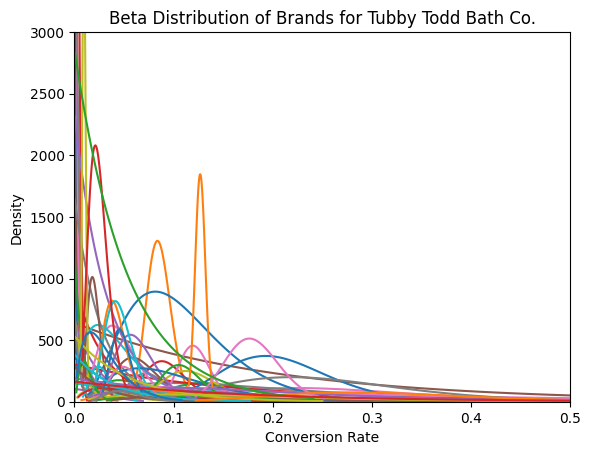

In [43]:
def draw_beta_dist(input_df):
    df = input_df.copy()
    #Draw a beta distribution for each row
    publisher = df['PUBLISHER'].iloc[0]
    for i, row in df.iterrows():
        a = row['alpha']
        b = row['beta']
        cpc = row['Cost_Per_Conversion']
        x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
        adj_x = x * cpc
        y = beta.pdf(x, a, b)
        plt.plot(adj_x, y, label=row['BRAND_NAME'])
    plt.title(f'Beta Distribution of Brands for {publisher}')
    #Set xlimit to 0.5 
    plt.xlim(0, 0.5)
    #Set ylimit to 5000
    plt.ylim(0, 3000)
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    #plt.legend()
    plt.show()

draw_beta_dist(fill_alpha_beta(tubby_todd))

In [55]:
def bayesian_comparison_with_cost(df):
    """
    Adjusted Bayesian comparison taking Cost_Per_Conversion into account,
    and ranking brands based on their performance.

    Args:
    df (pd.DataFrame): DataFrame containing BRAND_NAME, alpha, beta, and Cost_Per_Conversion.

    Returns:
    pd.DataFrame: Ranked brands based on their adjusted aggregate "best" scores.
    """
    n_brands = len(df)
    prob_matrix = np.zeros((n_brands, n_brands))

    for i in range(n_brands):
        for j in range(n_brands):
            if i == j:
                # Probability of a brand being better than itself is not defined
                prob_matrix[i, j] = np.nan
            else:
                # Retrieve parameters for brand i
                alpha_i, beta_i = df.iloc[i]['alpha'], df.iloc[i]['beta']
                cost_i = df.iloc[i]['Cost_Per_Conversion']

                # Retrieve parameters for brand j
                alpha_j, beta_j = df.iloc[j]['alpha'], df.iloc[j]['beta']
                cost_j = df.iloc[j]['Cost_Per_Conversion']

                # Define a range of conversion rates for evaluation
                x = np.linspace(0, 1, 10000)
                
                # Adjust conversion rates by cost
                x_i_adjusted = x * cost_i
                x_j_adjusted = x * cost_j
                
                # Calculate the PDFs for both distributions at original conversion rates
                pdf_i = beta.pdf(x, alpha_i, beta_i)
                pdf_j = beta.pdf(x, alpha_j, beta_j)
                
                # Estimate "probability of being better" considering the cost
                prob_being_better = np.trapz(np.minimum(pdf_i * cost_i, pdf_j * cost_j), x) / np.trapz(pdf_i * cost_i, x)
                prob_matrix[i, j] = prob_being_better

    # Create a DataFrame from the matrix for better readability
    prob_df = pd.DataFrame(prob_matrix, index=df['BRAND_NAME'], columns=df['BRAND_NAME'])
    
    # Calculate the aggregate "best" score for each brand (ignoring NaN values)
    aggregate_best_scores = prob_df.mean(axis=1)
    
    # Create a DataFrame for the scores
    aggregate_scores_df = pd.DataFrame({'BRAND_NAME': aggregate_best_scores.index, 'AGG_BEST': aggregate_best_scores.values})
    
    # Rank the brands based on their aggregate "best" score
    ranked_brands = aggregate_scores_df.sort_values(by='AGG_BEST', ascending=False).reset_index(drop=True)

    return ranked_brands

tubby_todd_best_brands = bayesian_comparison_with_cost(fill_alpha_beta(tubby_todd))
tubby_todd_results = tubby_todd.merge(tubby_todd_best_brands, on='BRAND_NAME').sort_values('AGG_BEST', ascending=False)
tubby_todd_results.head(10)

,PUBLISHER,BRAND_NAME,CPA,CPO,BRAND_IMPRESSIONS,CONV_COUNT,NEW_CONV_COUNT,TOTAL_AD_SPEND,RPM,CVR,Cost_Per_Conversion,AGG_BEST
18,Tubby Todd Bath Co.,Bad Birdie,NaN,NaN,267,1,0,5.0,18.726592,0.003745,5.00,0.363658
21,Tubby Todd Bath Co.,Dollar Shave Club,30.0,0.0,104,1,0,5.0,48.076923,0.009615,5.00,0.326674
53,Tubby Todd Bath Co.,Volcom,15.0,8.0,296,1,0,8.0,27.027027,0.003378,8.00,0.324041
31,Tubby Todd Bath Co.,SolaWave,NaN,NaN,322,2,0,20.0,62.111801,0.006211,10.00,0.308341
49,Tubby Todd Bath Co.,woolino,NaN,NaN,1626,5,2,39.0,23.985240,0.003075,7.80,0.305433
62,Tubby Todd Bath Co.,Lalabu,NaN,NaN,1244,2,1,11.0,8.842444,0.001608,5.50,0.305285
41,Tubby Todd Bath Co.,"Dermaclara, LLC",NaN,NaN,461,3,0,30.0,65.075922,0.006508,10.00,0.297742
43,Tubby Todd Bath Co.,True Botanicals,NaN,NaN,169,2,0,10.0,59.171598,0.011834,5.00,0.292445
2,Tubby Todd Bath Co.,Dropps,25.0,0.0,778,3,1,35.0,44.987147,0.003856,11.67,0.291168
42,Tubby Todd Bath Co.,Carve Designs,NaN,NaN,110,1,0,10.0,90.909091,0.009091,10.00,0.280747


In [53]:
tubby_todd_results.sort_values('RPM', ascending=False).head(20)

,PUBLISHER,BRAND_NAME,CPA,CPO,BRAND_IMPRESSIONS,CONV_COUNT,NEW_CONV_COUNT,TOTAL_AD_SPEND,RPM,CVR,Cost_Per_Conversion,AGG_BEST
71,Tubby Todd Bath Co.,For Days,30.0,15.0,539,8,2,150.0,278.293135,0.014842,18.75,0.078447
6,Tubby Todd Bath Co.,Storq,NaN,NaN,632,5,0,140.0,221.518987,0.007911,28.00,0.149115
57,Tubby Todd Bath Co.,Caraway,NaN,NaN,1237,6,1,270.0,218.270008,0.004850,45.00,0.126540
40,Tubby Todd Bath Co.,Divi,NaN,NaN,3372,13,13,650.0,192.763938,0.003855,50.00,0.088844
66,Tubby Todd Bath Co.,Nanit,NaN,NaN,8226,41,16,1450.0,176.270362,0.004984,35.37,0.085281
12,Tubby Todd Bath Co.,Coterie,NaN,NaN,1143,9,9,148.5,129.921260,0.007874,16.50,0.179007
61,Tubby Todd Bath Co.,Caden Lane,NaN,NaN,113651,606,191,14412.0,126.809267,0.005332,23.78,0.045200
55,Tubby Todd Bath Co.,Coco Moon,NaN,NaN,249,3,0,30.0,120.481928,0.012048,10.00,0.210340
36,Tubby Todd Bath Co.,Bodily,NaN,NaN,8520,56,15,1017.0,119.366197,0.006573,18.16,0.116608
38,Tubby Todd Bath Co.,HATCH,40.0,10.0,2504,16,4,280.0,111.821086,0.006390,17.50,0.176902


In [54]:
#What is the correlation between the RPM and AGG_BEST columns?
tubby_todd_results[['RPM', 'AGG_BEST']].corr()

,RPM,AGG_BEST
RPM,1.0000,0.3428
AGG_BEST,0.3428,1.0000
